In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from skimage.feature import local_binary_pattern
from skimage.filters import gabor_kernel
import math
from skimage.feature import hog
# Import SVM
from sklearn import svm
import seaborn as sns
from sklearn.metrics import confusion_matrix


Image shape: (970, 849)


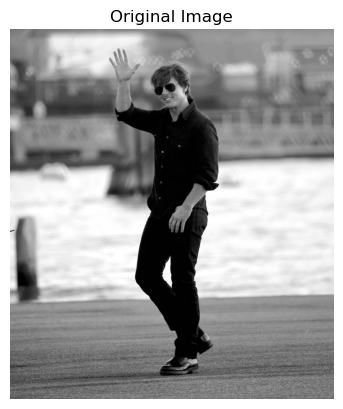

In [2]:
image= cv.imread('image.jpg', cv.IMREAD_GRAYSCALE)

print(f"Image shape: {image.shape}")
# Show the original image
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

In [3]:
def get_lbp(image, P=8, R=1, method='default'):
    lbp = local_binary_pattern(image, P, R, method=method)
    return lbp

In [4]:
LBP = get_lbp(image)
LBP_max_value = LBP.max()
print('LBP max value:', LBP_max_value)

LBP max value: 255.0


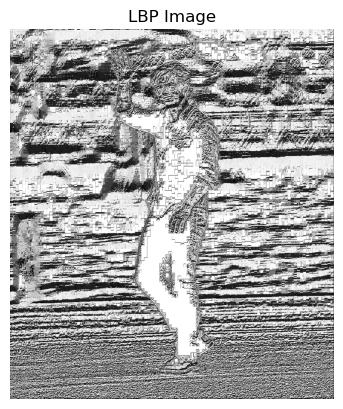

In [5]:
plt.imshow(LBP, cmap='gray')
plt.title('LBP Image')
plt.axis('off')
plt.show()

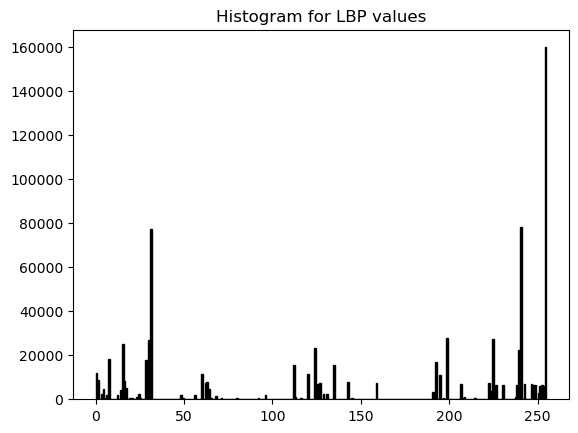

In [6]:
plt.hist(LBP.ravel(), bins=256, range=(0, LBP_max_value), fc='k', ec='k')
plt.title('Histogram for LBP values')
plt.show()

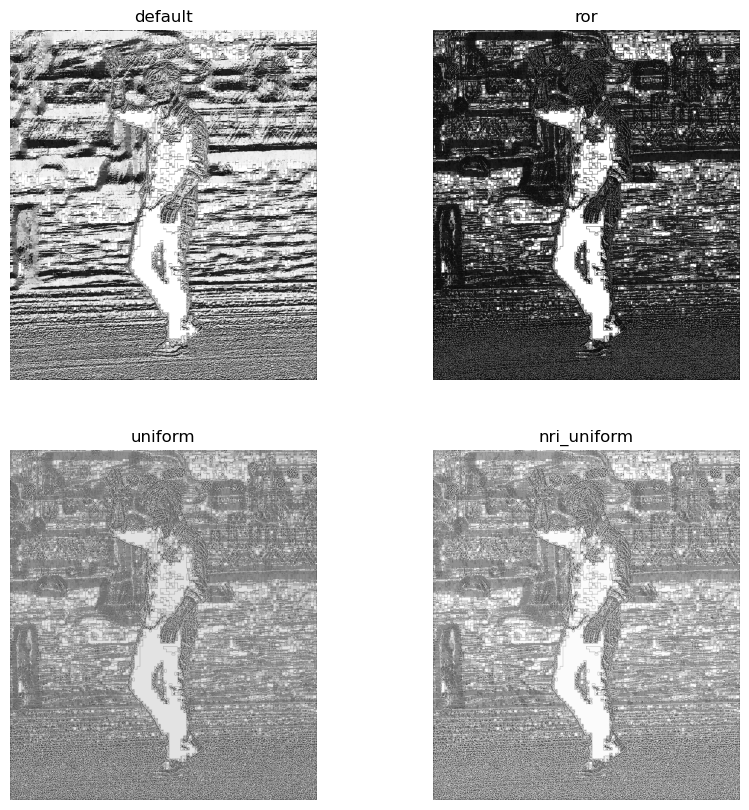

In [7]:
methods = ['default', 'ror', 'uniform', 'nri_uniform']
LBP_images_with_methods = [get_lbp(image, method=method) for method in methods]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(LBP_images_with_methods[i], cmap='gray')
    ax.set_title(methods[i])
    ax.axis('off')
plt.show()

In [8]:
# Print max value for each LBP image
LBP_max_values = [{method: LBP_image.max()} for method, LBP_image in zip(methods, LBP_images_with_methods)]
print('LBP max values:', LBP_max_values)

LBP max values: [{'default': 255.0}, {'ror': 255.0}, {'uniform': 9.0}, {'nri_uniform': 58.0}]


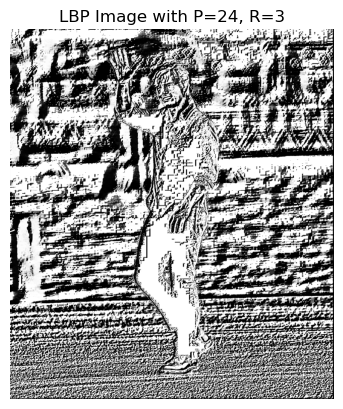

In [9]:
LBP_second_image = get_lbp(image, P=24, R=3, method='default')
plt.imshow(LBP_second_image, cmap='gray')
plt.title('LBP Image with P=24, R=3')
plt.axis('off')
plt.show()


The LBP (Local Binary Pattern) is a simple yet very efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number. It's a shift invariant texture operator, which means that it's robust against monotonic gray scale changes. The LBP operator can be used to measure local spatial patterns at different scales. Here are the observations I made with different LBP methods:

- **Default**: 
  - Standard LBP compares each pixel with its neighbors to form a binary pattern. Simple and fast, but sensitive to rotation and noise.

- **ROR (Rotation Invariant)**: 
  - Creates rotation-invariant patterns by considering all rotations of the binary pattern and selecting the smallest. Useful for texture classification where rotation doesn't matter.

- **Uniform**: 
  - Only patterns with at most two bitwise transitions (e.g., 00011111) are used, reducing feature space and improving robustness to noise.

- **NRI Uniform (Non-Rotation Invariant Uniform)**: 
  - Similar to Uniform but without rotation invariance, focusing on texture patterns with minimal transitions.


Next, we changed **R (radius)** and **P (number of neighbors)** parameters to see how they affect the performance of the LBP method. Here I briefly summarize the results:


- **R (Radius)**:
  - Defines the distance from the center pixel to the neighboring pixels. A larger **R** captures a broader neighborhood, providing more context but increasing computational complexity.
  - **Effect**: Larger **R** values capture more global texture features, while smaller **R** values focus on finer, more local textures.

- **P (Points)**:
  - Specifies the number of sampling points around the center pixel. More points provide finer resolution in texture patterns, but increase computation.
  - **Effect**: Higher **P** increases the pattern's precision and captures more detailed texture, but also makes it more sensitive to noise.

### Summary:
- **R**: Affects spatial scale (local vs. global texture).
- **P**: Affects pattern resolution (detail vs. simplicity).

In [11]:
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
gabor_images = []
for theta in thetas:
    kernel = cv.getGaborKernel(ksize=(21, 21), sigma=5, theta=theta, lambd=10, gamma=0.5, psi=0, ktype=cv.CV_32F)
    gabor_images.append({'theta': theta, 'image': cv.filter2D(image, ddepth=-1, kernel=kernel)})

In [ ]:
print('Gabor images with theta values:', [gabor_image['theta'] for gabor_image in gabor_images])

Gabor images with theta values: [0, 45, 90, 135]


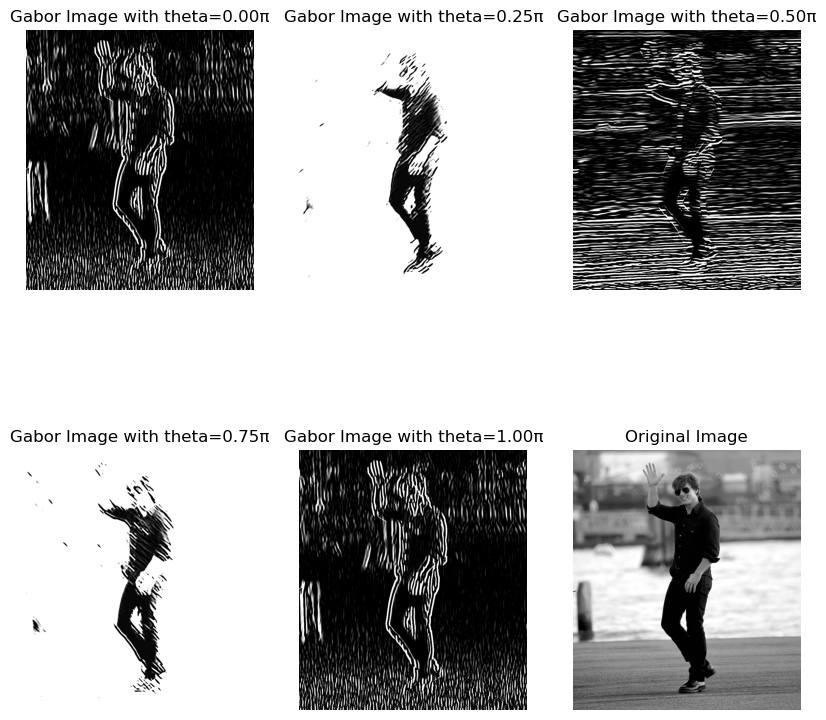

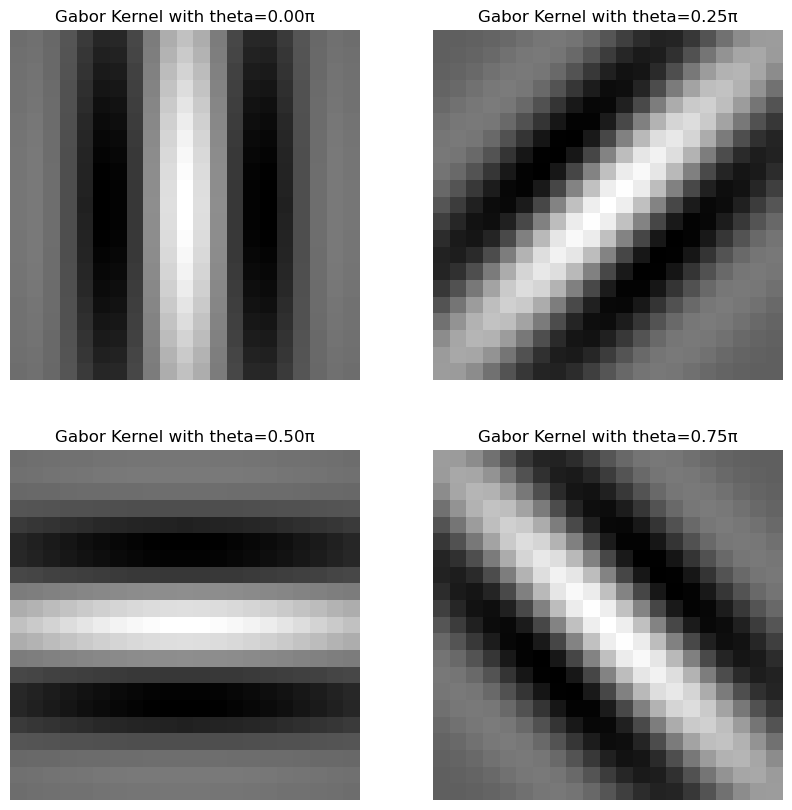

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(gabor_images[i]['image'], cmap='gray')
    ax.set_title(f'Gabor Image with theta={gabor_images[i]["theta"]/np.pi:.2f}π')
    ax.axis('off')
    if i == 4:
        break
# Merge the last axis and plot the original image
axs[1, 2].imshow(image, cmap='gray')
axs[1, 2].set_title('Original Image')
axs[1, 2].axis('off')
axs[1, 1].axis('off')
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(ax.flat):
    kernel = cv.getGaborKernel(ksize=(21, 21), sigma=5, theta=thetas[i], lambd=10, gamma=0.5, psi=0, ktype=cv.CV_32F)
    ax.imshow(kernel, cmap='gray')
    ax.set_title(f'Gabor Kernel with theta={thetas[i]/np.pi:.2f}π')
    ax.axis('off')
plt.show()

In [23]:
sigma_values = [1, 2, 3]
lambda_values = [2, 4, 6, 8]
gamma_values = [0.3, 1, 1.3]
theta = np.pi/4
gabor_images = []
for sigma in sigma_values:
    for lambda_ in lambda_values:
        for gamma in gamma_values:
            kernel = cv.getGaborKernel((21, 21), sigma, theta, lambda_, gamma, 0, ktype=cv.CV_32F)
            gabor_images.append({'sigma': sigma, 'lambda': lambda_, 'gamma': gamma, 'image': cv.filter2D(image, ddepth=-1, kernel=kernel)})
print('Number of Gabor images:', len(gabor_images))
number_of_images = len(gabor_images)

Number of Gabor images: 36


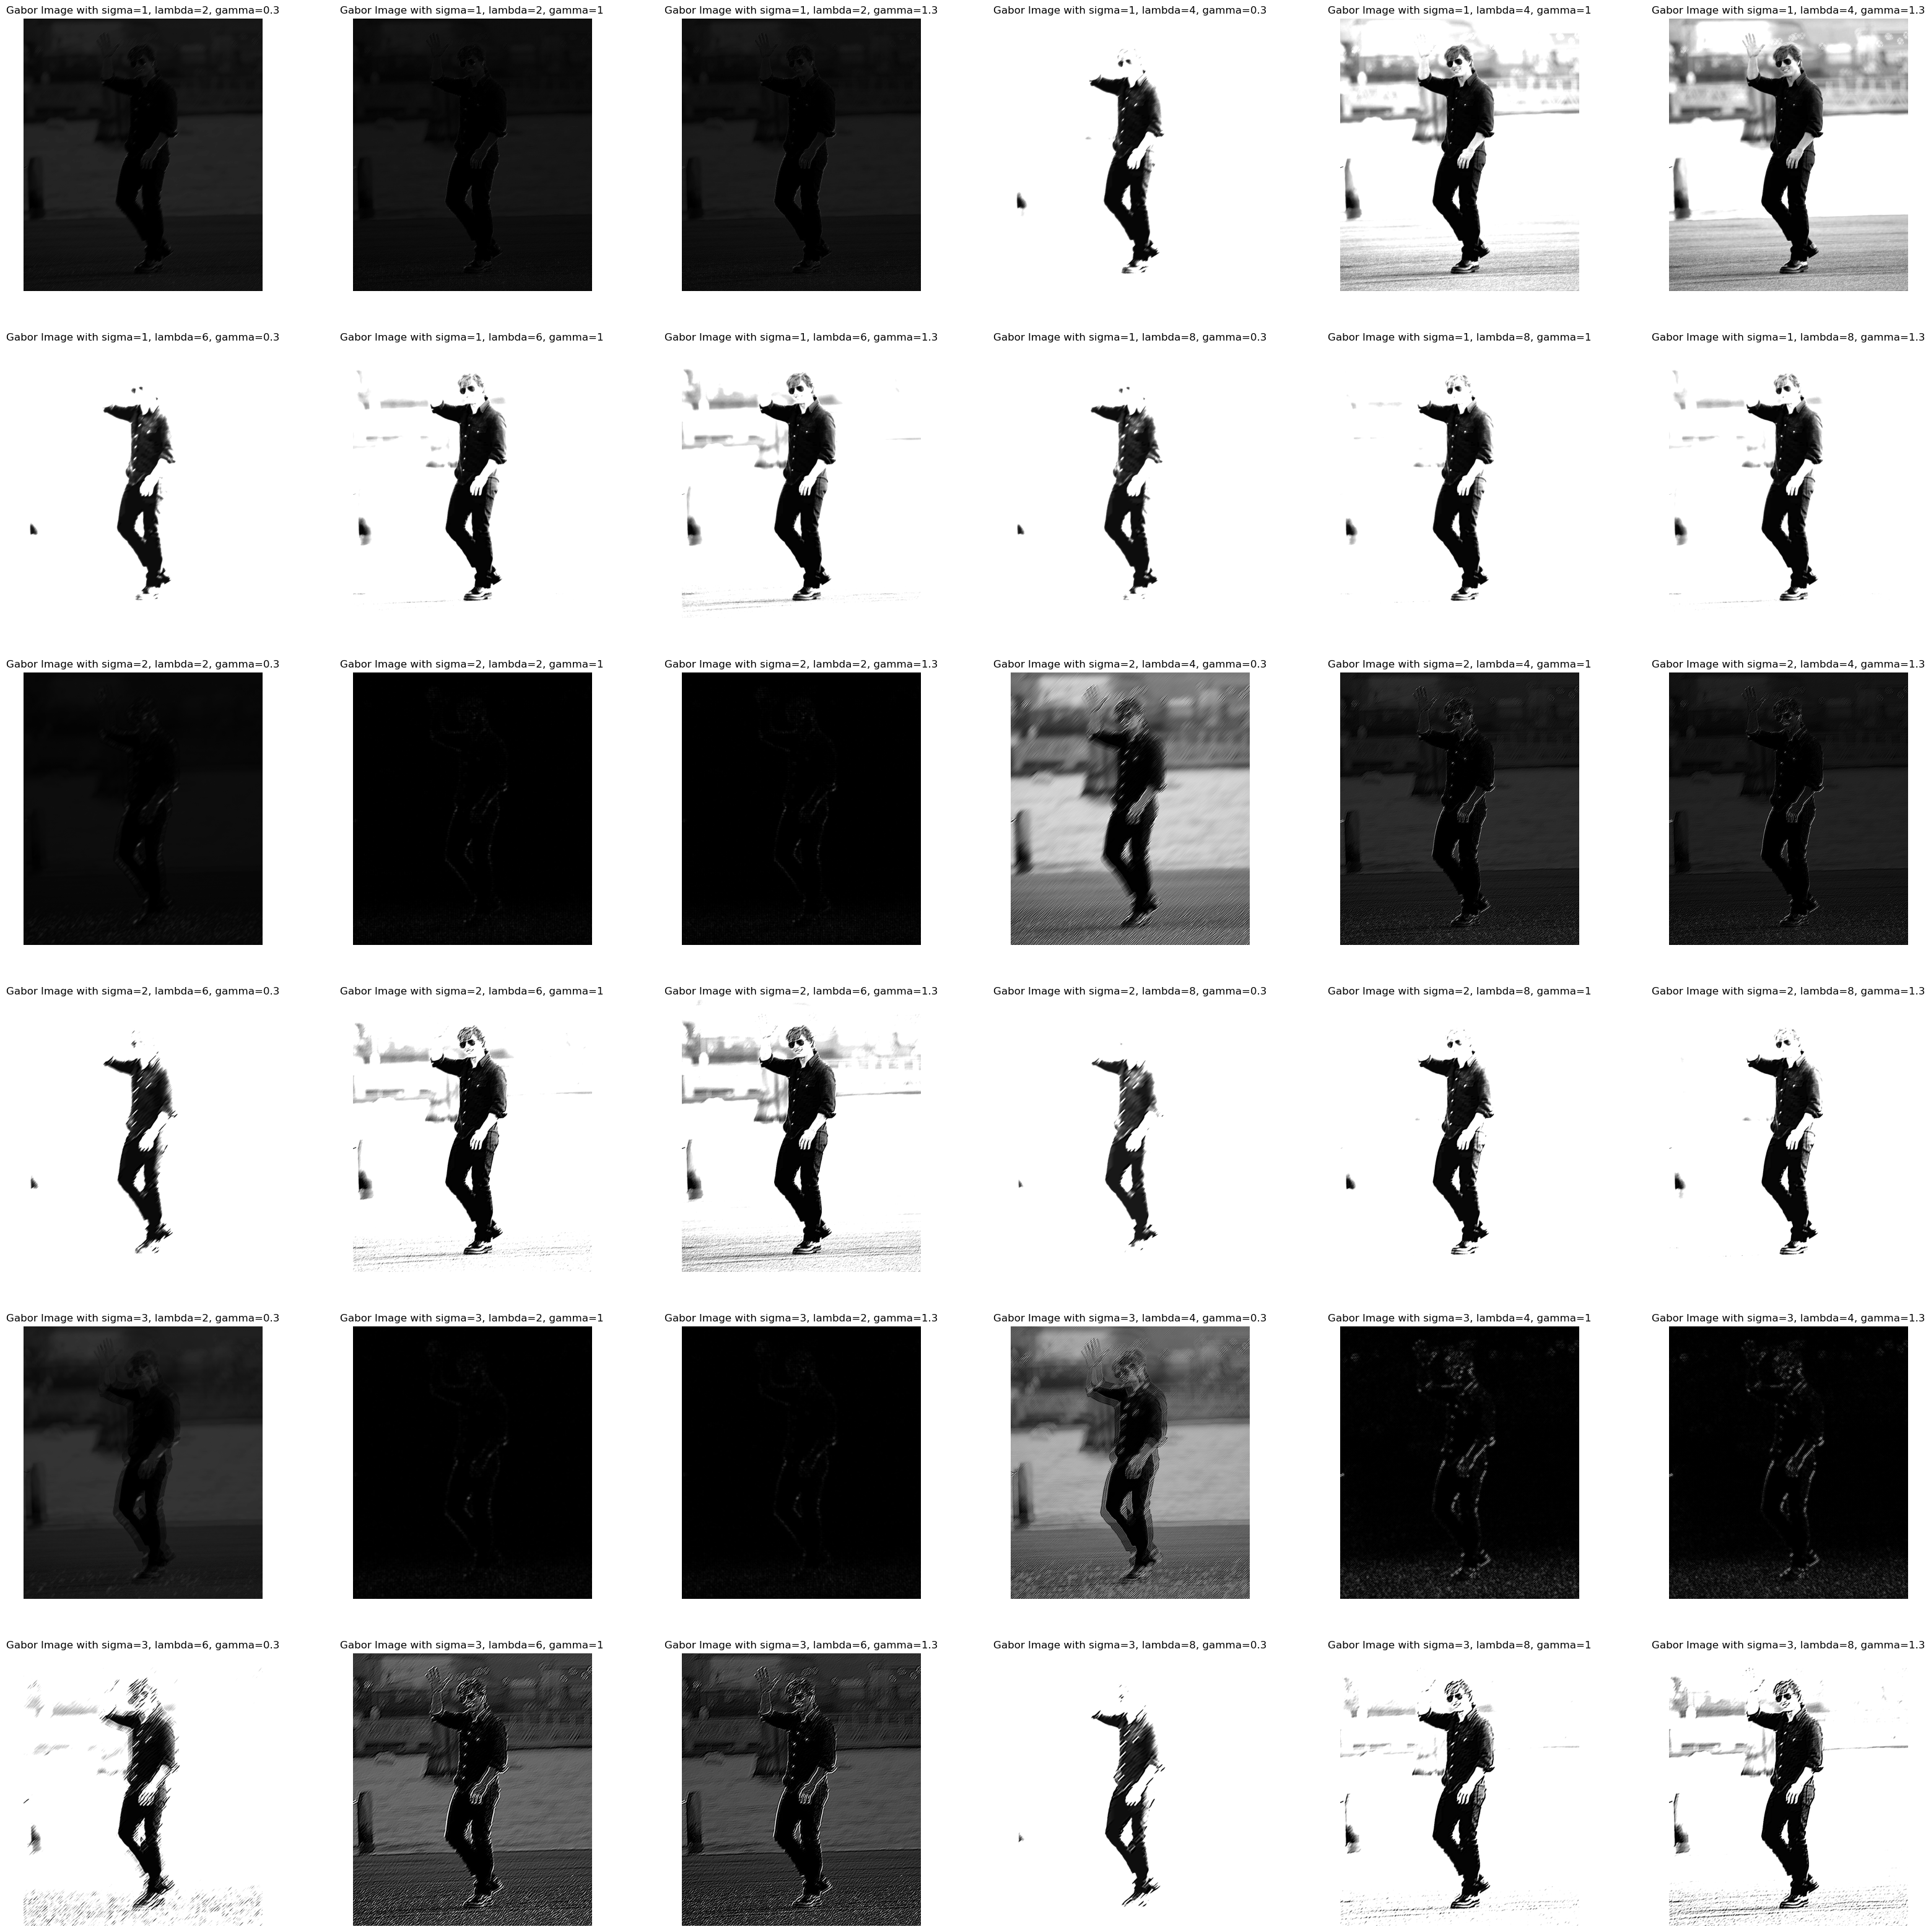

In [24]:
sqrt_number_of_images = math.ceil(math.sqrt(number_of_images))
fig, axs = plt.subplots(sqrt_number_of_images, sqrt_number_of_images, figsize=(40, 40))
for i, ax in enumerate(axs.flat):
    if i < number_of_images:
        ax.imshow(gabor_images[i]['image'], cmap='gray')
        ax.set_title(f'Gabor Image with sigma={gabor_images[i]["sigma"]}, lambda={gabor_images[i]["lambda"]}, gamma={gabor_images[i]["gamma"]}')
        ax.axis('off')
    else:
        ax.axis('off')
plt.show()

As it's shown in the instructions, the Gabor filter is a shift-invariant linear filter that is designed to capture the texture of an image. The filter gets **sigma**, **lambda**, **gamma**, and **theta** as its parameters. Here are the observations I made while changing these parameters:

- **Sigma**: 
  - Increasing sigma (1 → 3) broadens the filter, capturing larger structures.
  
- **Lambda**: 
  - Increasing lambda (2 → 8) captures coarser textures, smaller values detect finer details.

- **Gamma**: 
  - Gamma = 1: Isotropic, sensitive to all orientations.
  - Gamma < 1 (0.3): Vertical features.
  - Gamma > 1 (1.3): Horizontal features.


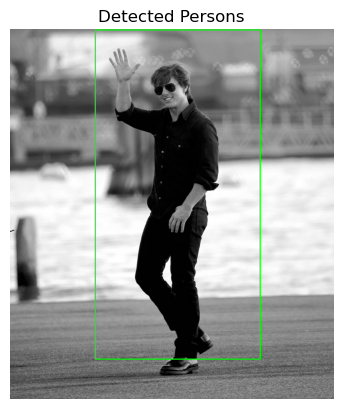

In [25]:
hog = cv.HOGDescriptor()
hog.setSVMDetector(cv.HOGDescriptor_getDefaultPeopleDetector())

image = cv.imread('image.jpg', cv.IMREAD_GRAYSCALE)

(rects, weights) = hog.detectMultiScale(image, winStride=(4, 4), padding=(8, 8), scale=1.05)

threshold = max(weights) / 2

valid_rects = []
for (rect, weight) in zip(rects, weights):
    if weight > threshold:
        valid_rects.append(rect)

# Get biggest rectangle
biggest_rect = max(valid_rects, key=lambda x: x[2] * x[3])

# Draw the biggest rectangle
image = cv.cvtColor(image, cv.COLOR_GRAY2RGB)
cv.rectangle(image, (biggest_rect[0], biggest_rect[1]), (biggest_rect[0] + biggest_rect[2], biggest_rect[1] + biggest_rect[3]), (0, 255, 0), 2)


plt.imshow(image, cmap='gray')
plt.title('Detected Persons')
plt.axis('off')
plt.show()

In [ ]:
def load_images_from_folder(folder_path):
    images = []
    for file_name in os.listdir(folder_path):
        image = cv.imread(os.path.join(folder_path, file_name), cv.IMREAD_GRAYSCALE)
        if image is not None:
            images.append(image)
    return images

In [ ]:
disgust_images_path = 'Data/images/disgust'
happy_images_path = 'Data/images/happy'

disgust_images = load_images_from_folder(disgust_images_path)
happy_images = load_images_from_folder(happy_images_path)

print(f'Number of disgust images: {len(disgust_images)}')
print(f'Number of happy images: {len(happy_images)}')

print(f'Image shape: {disgust_images[0].shape}')

Number of disgust images: 47
Number of happy images: 85
Image shape: (600, 300)


In [ ]:
def crop_white(gray_image):
    _, threshold = cv.threshold(gray_image, 0, 15, cv.THRESH_BINARY)
    inverted_threshold = cv.bitwise_not(threshold)
    contours, _ = cv.findContours(inverted_threshold, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv.boundingRect(contours[0])
        cropped_image = gray_image[y:y+h, x:x+w]
        return cropped_image
    
    return gray_image

def fit_size(images):
    min_shape_x = 0
    min_shape_y = 0
    for image in images:
        if image.shape[0] > min_shape_y:
            min_shape_y = image.shape[0]
        if image.shape[1] > min_shape_x:
            min_shape_x = image.shape[1]
    print(f"Min shape: {min_shape_x}x{min_shape_y}")
    return np.array([cv.resize(img, (min_shape_x, min_shape_y)) for img in images])

def mask_images(images):
    masked_images = []
    for gray in images:
        # Mask the central part of the image
        mask = np.zeros(gray.shape, np.uint8)
        shape = gray.shape
        center = (shape[1] // 2, shape[0] // 2)
        radius_x = math.floor(shape[1] / 2.2)
        radius_y = math.floor(shape[0] / 2.5)

        mask = cv.ellipse(mask, center, (radius_x, radius_y), 0, 0, 360, 255, -1)
        masked_img = cv.bitwise_and(gray, gray, mask=mask)

        masked_images.append(masked_img)
    
    return masked_images

def preprocess_images(images):
    print(images[0].shape)
    cropped_images = [crop_white(image) for image in images]
    print(cropped_images[0].shape)
    fitted_images = fit_size(cropped_images)
    masked_images = mask_images(fitted_images)
    return masked_images


disgust_images_masked = preprocess_images(disgust_images)
happy_images_masked = preprocess_images(happy_images)

(600, 300)
(600, 300)
Min shape: 300x600
(600, 300)
(600, 300)
Min shape: 300x600


In [ ]:
shuffled_disgust_images = np.random.permutation(disgust_images_masked)
shuffled_happy_images = np.random.permutation(happy_images_masked)

train_disgust_images = shuffled_disgust_images[:35]
train_happy_images = shuffled_happy_images[:65]

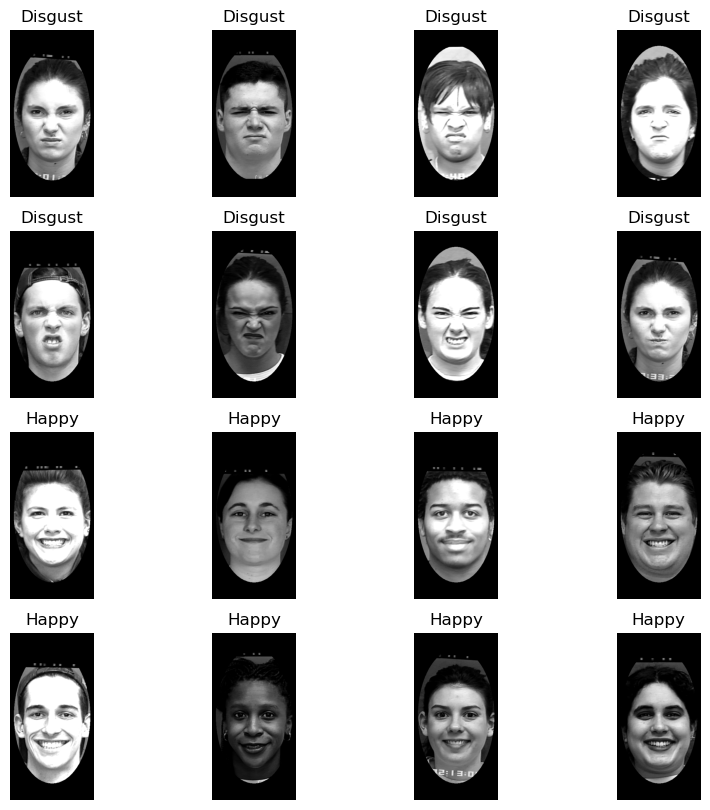

In [ ]:
# Plot the first 2 disgust and happy images
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    if i < 8:
        ax.imshow(train_disgust_images[i], cmap='gray')
        ax.set_title('Disgust')
    else:
        ax.imshow(train_happy_images[i-4], cmap='gray')
        ax.set_title('Happy')
    ax.axis('off')
plt.show()


In [ ]:
happy_image_features = [hog(image, orientations=8, pixels_per_cell=(16, 16)) for image in train_happy_images]
disgust_image_features = [hog(image, orientations=8, pixels_per_cell=(16, 16)) for image in train_disgust_images]

print(f'Number of happy image features: {happy_image_features[0].shape}')
print(f'Number of disgust image features: {disgust_image_features[0].shape}')


Number of happy image features: (40320,)
Number of disgust image features: (40320,)


In [ ]:
# Train the SVM model
X_train = np.array(happy_image_features + disgust_image_features)
y_train = np.array([1] * len(happy_image_features) + [0] * len(disgust_image_features))

clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [ ]:
# Test the model
test_disgust_images = shuffled_disgust_images[35:]
test_happy_images = shuffled_happy_images[65:]

happy_image_features = [hog(image, orientations=8, pixels_per_cell=(16, 16)) for image in test_happy_images]
disgust_image_features = [hog(image, orientations=8, pixels_per_cell=(16, 16)) for image in test_disgust_images]

X_test = np.array(happy_image_features + disgust_image_features)
y_test = np.array([1] * len(happy_image_features) + [0] * len(disgust_image_features))

y_pred = clf.predict(X_test)

accuracy = np.mean(y_pred == y_test)

In [ ]:
print(f'Accuracy: {accuracy}')

Accuracy: 0.96875


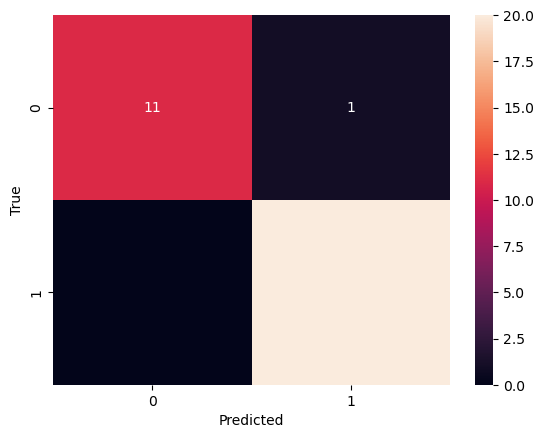

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
